In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

In [3]:
bnb_listings = pd.read_csv('data/listings.csv')
bnb_cal = pd.read_csv('data/calendar.csv')

#Clean up price column
bnb_cal['price'].fillna(0, inplace=True)

def money_str_to_float(x):
    if type(x) == str:
        x = x.replace('$','')
        x = x.replace(',','')
        return float(x)
    elif type(x) == int:
        return float(x)

bnb_cal['price'] = bnb_cal['price'].apply(lambda x: money_str_to_float(x))

In [4]:
#How much money does each unit earn, on average, by day
earnings_per_day = bnb_cal.groupby('listing_id').mean()

In [5]:
earnings_per_day['id'] = earnings_per_day.index
earnings_per_day = earnings_per_day.reset_index().drop(columns = 'listing_id')
earnings_per_day.head()

,price,id
0,101.589041,3335
1,82.000000,4291
2,45.668493,5682
3,92.849315,6606
4,12.342466,7369


In [6]:
bnb_listings_master = bnb_listings[['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet',
 'price',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'calendar_updated',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'calendar_last_scraped',
 'number_of_reviews',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'requires_license',
 'license',
 'jurisdiction_names',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'calculated_host_listings_count',
 'reviews_per_month']]

In [7]:
bnb_listings_abbrev = bnb_listings[['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bed_type',
 'amenities',
 'square_feet',
 'price',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'calendar_updated',
 'has_availability',
 'availability_90',
 'availability_365',
 'calendar_last_scraped',
 'number_of_reviews',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'requires_license',
 'license',
 'jurisdiction_names',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'calculated_host_listings_count',
 'reviews_per_month']]

In [8]:
bnb_merge = bnb_listings_abbrev.merge(earnings_per_day, how = 'inner', on = 'id')
bnb_merge['avg_earnings'] = bnb_merge['price_y']
bnb_merge = bnb_merge.drop(columns = 'price_y')
target_metric = 'availability_90'
#Note that price / day is now price_y

In [9]:
merged_numerics = bnb_merge.select_dtypes(include = np.number, exclude = object)
merged_numerics = merged_numerics.drop(columns = ['square_feet','license'])
merged_numerics = merged_numerics.dropna()

In [10]:
def generate_collinearity_pairs(x):

    # save absolute value of correlation matrix as a data frame
    # converts all values to absolute value
    # stacks the row:column pairs into a multindex
    # reset the index to set the multindex to seperate columns
    # sort values. 0 is the column automatically generated by the stacking

    df=x.corr().abs().stack().reset_index().sort_values(0, ascending=False)

    # zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
    df['pairs'] = list(zip(df.level_0, df.level_1))

    # set index to pairs
    df.set_index(['pairs'], inplace = True)

    #d rop level columns
    df.drop(columns=['level_1', 'level_0'], inplace = True)

    # rename correlation column as cc rather than 0
    df.columns = ['cc']

    # drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
    # for the sake of exercise, kept it in.
    df.drop_duplicates(inplace=True)

    return df

In [11]:
df = generate_collinearity_pairs(merged_numerics)
df[(df.cc>.75) & (df.cc <1)]
#This was used to drop availability_60, availability_30, beds, bedrooms from the bnb_listings_abbreviated dataframe above

,cc
pairs,


In [12]:
#Make a multiple linear regression model to check parameters performance on predicting target metric (chosen above in cell 3)
y = merged_numerics[target_metric]
x = sm.add_constant(merged_numerics.drop(columns=[target_metric]))
model = sm.OLS(y,x).fit()
model.summary()

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        availability_90   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     101.6
Date:                Sat, 26 Mar 2022   Prob (F-statistic):          3.24e-296
Time:                        18:17:30   Log-Likelihood:                -14786.
No. Observations:                3158   AIC:                         2.961e+04
Df Residuals:                    3139   BIC:                         2.973e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
id                             -9.853e-08   2.25e-07     -0.437      0.662    -5.4e-07    3.43e-07
scrape_id                       2.721e-11   9.28e-11      0.293      0.769   -1.55e-10    2.09e-10
host_listings_count                0.0566      0.010      5.745      0.000       0.037       0.076
host_total_listings_count          0.0566      0.010      5.745      0.000       0.037       0.076
latitude                         -19.6141     11.181     -1.754      0.079     -41.537       2.309
longitude                         -3.4765     15.385     -0.226      0.821     -33.642      26.689
accommodates                      -1.3053      0.340     -3.836      0.000      -1.972      -0.638
guests_included                    0.3566      0.434      0.822      0.411      -0.495       1.208
minimum_nights                     0.0203      0.026      0.778      0.437      -0.031       0.072
maximum_nights                 -8.645e-05      0.000     -0.338      0.735      -0.001       0.000
availability_365                   0.1429      0.005     28.856      0.000       0.133       0.153
number_of_reviews                 -0.0274      0.019     -1.470      0.142      -0.064       0.009
review_scores_rating               0.0210      0.122      0.172      0.863      -0.219       0.261
review_scores_accuracy            -0.4620      0.911     -0.507      0.612      -2.247       1.323
review_scores_cleanliness          2.7973      0.799      3.499      0.000       1.230       4.365
review_scores_checkin              0.2225      1.144      0.195      0.846      -2.020       2.465
review_scores_communication       -0.4452      1.232     -0.361      0.718      -2.862       1.971
review_scores_location            -1.7511      0.846     -2.069      0.039      -3.410      -0.092
review_scores_value               -2.6793      0.922     -2.906      0.004      -4.487      -0.872
calculated_host_listings_count     0.2404      0.084      2.863      0.004       0.076       0.405
reviews_per_month                  2.7750      0.363      7.654      0.000       2.064       3.486
avg_earnings                       0.0203      0.008      2.575      0.010       0.005       0.036
==============================================================================
Omnibus:                       45.197   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.196
Skew:                          -0.263   Prob(JB):                     2.53e-10
Kurtosis:                       2.756   Cond. No.                     3.24e+27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.2

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


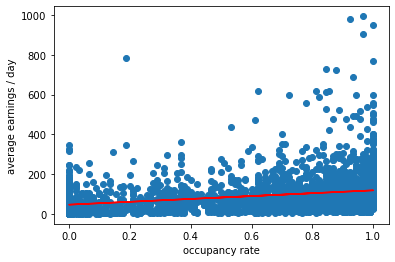

In [13]:
fig, ax = plt.subplots()
plt.scatter(merged_numerics['availability_90'] / 90,merged_numerics['avg_earnings'])

occupancy_model = sm.OLS(merged_numerics['avg_earnings'], sm.add_constant(merged_numerics['availability_90'])).fit()
b,m = occupancy_model.params
plt.plot(merged_numerics['availability_90'] / 90,merged_numerics['availability_90']*m + b, c = 'r')
plt.ylabel('average earnings / day')
plt.xlabel('occupancy rate');

In [17]:
bnb_merge.to_csv('data/earnings_data.csv')